In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

numpy version:  1.13.1
astropy version:  3.1.dev21950
asdf version:  2.1.0.dev1406
gwcs version:  0.10.dev370
jwst version:  0.9.8a.dev32+g360261cf /internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# May need to change the path to "strun"
#!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg nrs1_fs.fits

In [4]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")
esa.remove("esa/Trace_SLIT_B_200_V84600010001P0000000002101_39547_JLAB88.fits")
map_slit_names = {'SLIT_A_1600' : 'S1600A1',
                  'SLIT_A_200_1': 'S200A1',
                  'SLIT_A_200_2': 'S200A2',
                  'SLIT_A_400':   'S400A1',
                  }

In [5]:
im = datamodels.ImageModel('nrs1_fs_assign_wcs.fits')

** Working with the WCS object **

The Nirspec WCS object stores the WCS information for all slits. We need to retrieve the
WCS for a particular slit before we can evaluate the transforms. Currently this is done by
calling a function in assign_wcs.nirspec.py

In [6]:
slit_wcs = nirspec.nrs_wcs_set_input(im, 'S200A1')
print(slit_wcs)

   From       Transform    
---------- ----------------
  detector          dms2sca
       sca CompoundModel424
       gwa CompoundModel106
slit_frame CompoundModel426
 msa_frame        msa2oteip
     oteip        oteip2v23
      v2v3      v2v3_to_sky
     world             None


The WCS object has a bounding_box attribute which shows the valid range of input values.
Inputs outside the bounding_box return NaN. 

In [7]:
print('slit_wcs.bounding_box: ', slit_wcs.bounding_box)
print("inputs outside the bounding_box: ", slit_wcs(100, 100))
print("valid inputs: ", slit_wcs(700, 1080))

slit_wcs.bounding_box:  ((666.33841181811158, 2047.0), (1055.1643125378851, 1098.6462304694655))
inputs outside the bounding_box:  (nan, nan, nan)
valid inputs:  (156.19118798721524, -45.68247754856884, 0.9840815805764577)


In different observing modes the WCS may have different coordinate frames. 
To check the available frames:

In [8]:
slit_wcs.available_frames

['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'world']

Transforms between different frames can be retrieved and evaluated to give coordinates in the respective plane.
The order of the frames matter - if switched the reverse transform is retrieved.

In [9]:
det2slit = slit_wcs.get_transform('detector', 'slit_frame')
slitx, slity, lam = det2slit(700, 1080)
print("slitx: " , slitx)
print("slity: " , slity)
print("lambda: " , lam)

slitx:  -0.0
slity:  0.05492205382254404
lambda:  9.840815805764577e-07


The number of inputs and outputs in each frame vary but can be checked by

In [10]:
print('Number on inputs: ', det2slit.n_inputs)
print('Number on outputs: ', det2slit.n_outputs)

Number on inputs:  2
Number on outputs:  3


In [11]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res
    

** Testing - wavelengths **

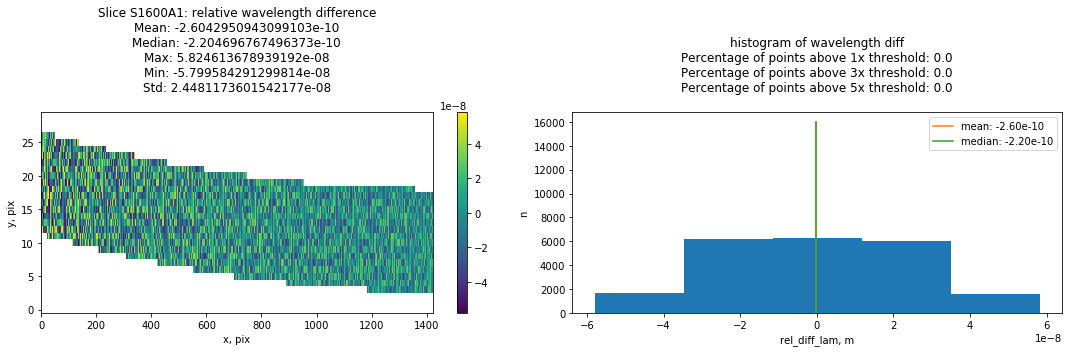

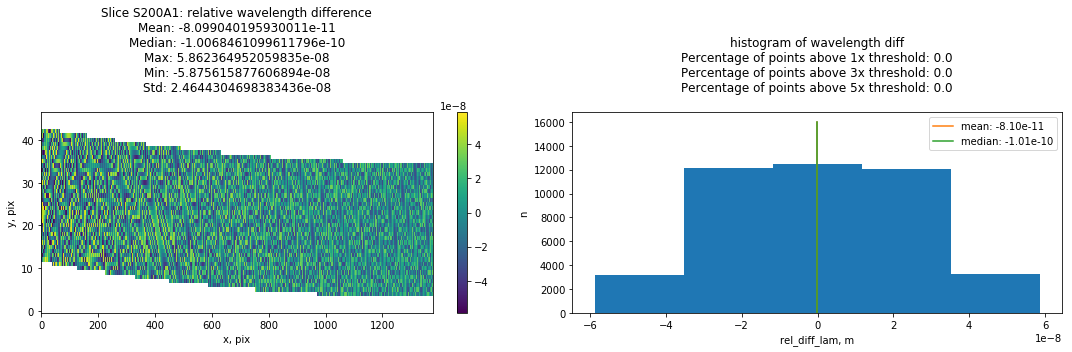

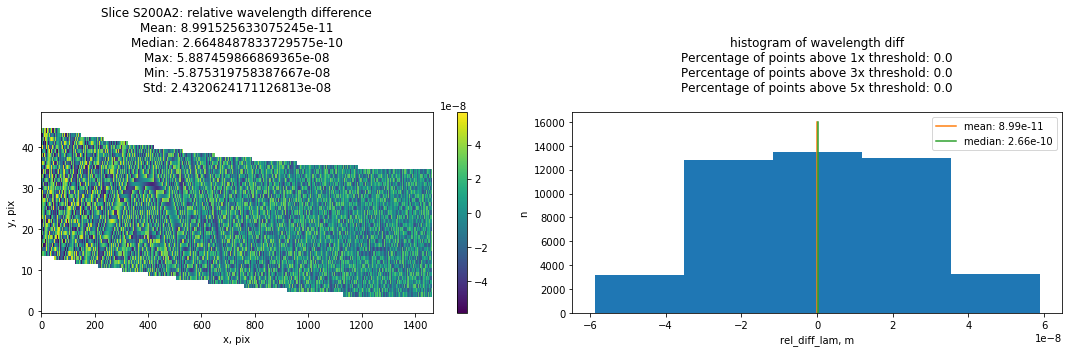

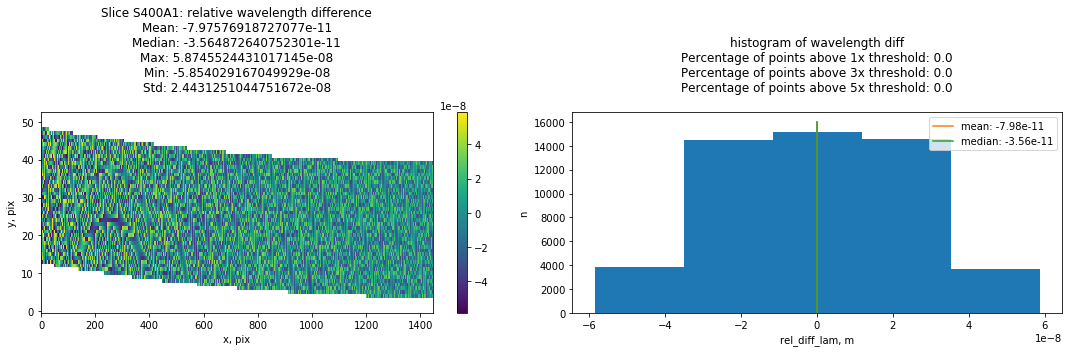

In [12]:
#esa = ["esa/Trace_SLIT_A_200_1_V84600010001P0000000002101_39547_JLAB88.fits"]
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)
    
    
    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1-1, y1-1)
    lam *= 10**-6

    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    lam[~in_slit] = np.nan
    nanind = np.isnan(lam)
    notnan = ~nanind
    # Set lam values outside the slit to NaN
    lam[nanind] = np.nan
    # Add to nanind all indices where values returned by the pipeline are NaNs
    #nanind = np.isnan(lam)
    #notnan = ~nanind
    # Set the values to NaN in the ESA lambda extension
    lam1[nanind] = np.nan

    # Compute the difference in wavelength
    rel_diff_lam = (lam1 - lam) / lam1
    
    # Compute statistics for notnan indices
    mean = np.mean(rel_diff_lam[notnan])
    median = np.median(rel_diff_lam[notnan])
    dmax = np.max(rel_diff_lam[notnan])
    dmin = np.min(rel_diff_lam[notnan])
    dstd = np.std(rel_diff_lam[notnan])
    percentage_results = compute_percentage(rel_diff_lam, 1e-7)
    
    title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of wavelength diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(rel_diff_lam, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('rel_diff_lam, m')
    plt.ylabel('n')
    fig.tight_layout()

In [13]:
print("Working on exposure type {0}".format(im.meta.exposure.type))
print("grating: {0}".format(im.meta.instrument.grating))
print("filter: {0}".format(im.meta.instrument.filter))
print("GWA tilt correction:")
print("gwa_ytilt is 0.1260581910610199 deg")
print("gwa_xtilt is 0.3316612243652344 deg")
print("Final disperser THETA_Y angle is 0.12630780104069161 deg")

print("theta_x correction: 0.0 deg")
print("theta_y correction: {0} arcsec".format(0.0002496099796717191 * 3600))
print("Theta_y correction in Trace file is {0}".format(fits.getval(esa[0], "THETAY")))

Working on exposure type NRS_FIXEDSLIT
grating: G140M
filter: F100LP
GWA tilt correction:
gwa_ytilt is 0.1260581910610199 deg
gwa_xtilt is 0.3316612243652344 deg
Final disperser THETA_Y angle is 0.12630780104069161 deg
theta_x correction: 0.0 deg
theta_y correction: 0.8985959268181888 arcsec
Theta_y correction in Trace file is 0.8985959268181887


**Slit-y positions**

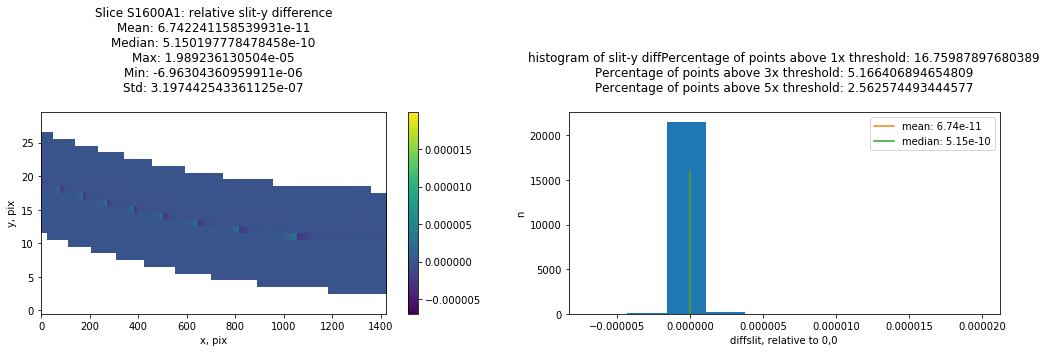

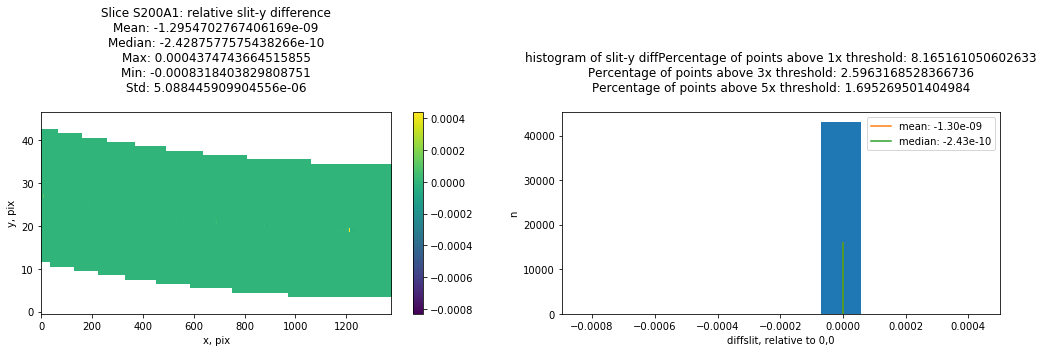

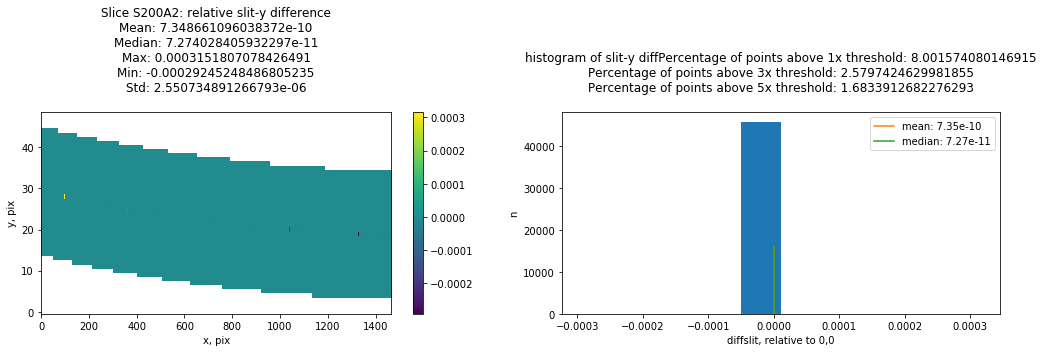

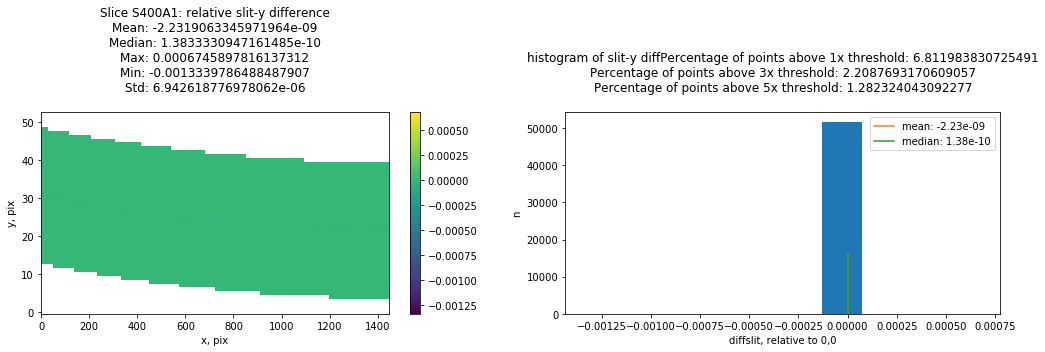

In [14]:

for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)
    
    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, lam = detector2slit(x1-1, y1-1)
    
    # Use slit locations between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    sy[~in_slit] = np.nan
    nanind = np.isnan(sy)
    notnan = ~nanind
    diffslit = (sy - slit1) / slit1
    percentage_results = compute_percentage(diffslit, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffslit[notnan])
    median = np.median(diffslit[notnan])
    dmax = np.max(diffslit[notnan])
    dmin = np.min(diffslit[notnan])
    dstd = np.std(diffslit[notnan])
    
    title1 = "Slice {}: relative slit-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of slit-y diff"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffslit, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffslit[~np.isnan(diffslit)].flatten(), bins=10)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffslit, relative to 0,0')
    plt.ylabel('n')
    fig.tight_layout()

### MSA_Y position

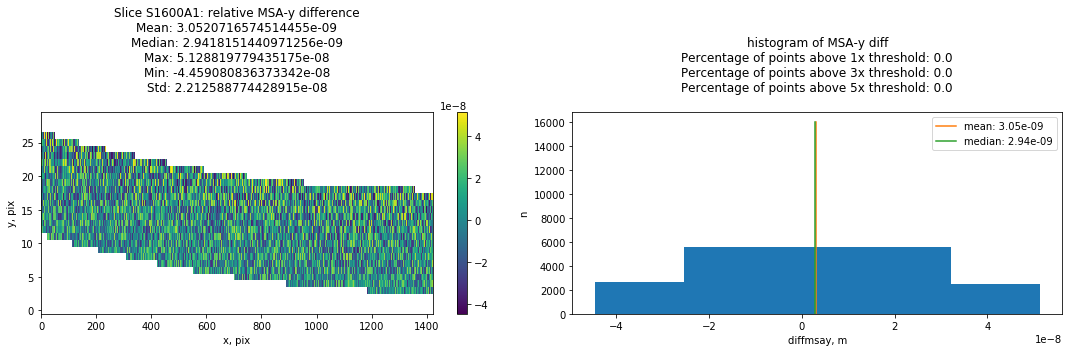

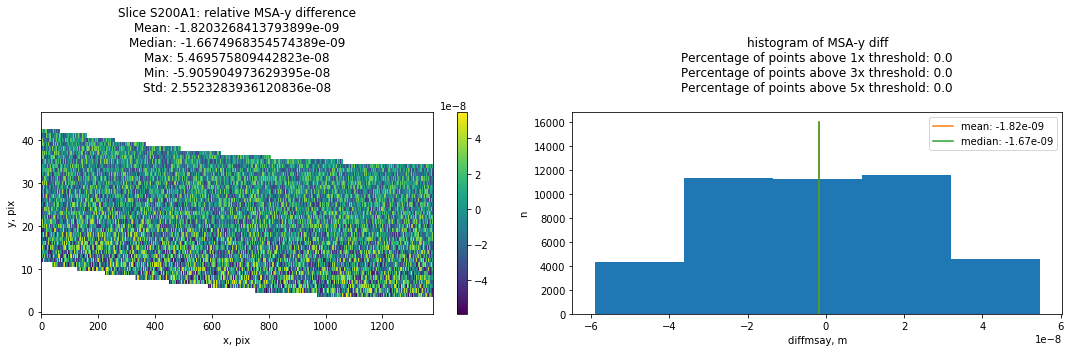

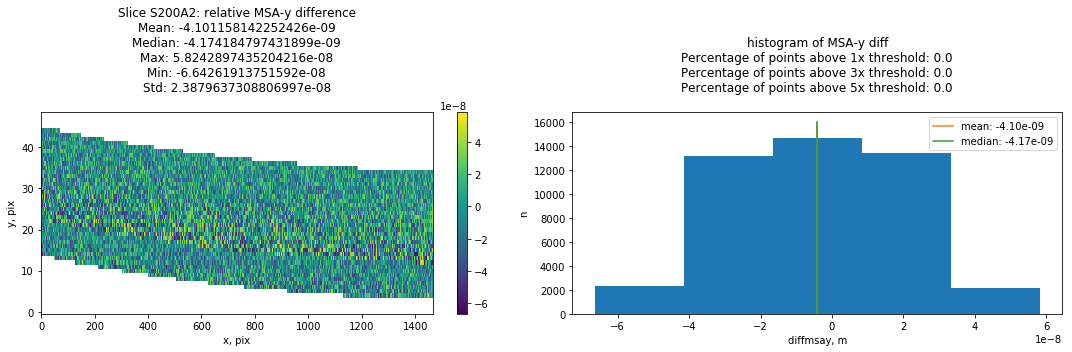

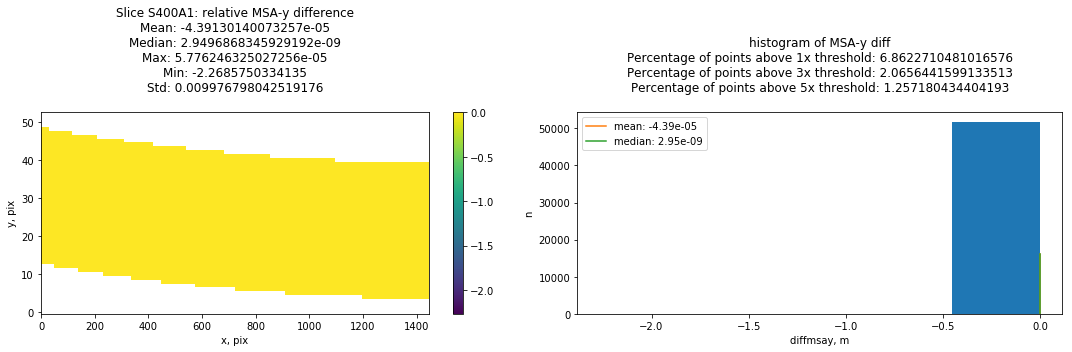

In [15]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msay1 = tr['MSAY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in MSA positions
    detector2slit = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2slit(x1-1, y1-1)
    
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    my[~in_slit] = np.nan
    nanind = np.isnan(my)
    notnan = ~nanind
    
    diffmsay = (my - msay1) / msay1
    percentage_results = compute_percentage(diffmsay, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsay[notnan])
    median = np.median(diffmsay[notnan])
    dmax = np.max(diffmsay[notnan])
    dmin = np.min(diffmsay[notnan])
    dstd = np.std(diffmsay[notnan])

    title1 = "Slice {}: relative MSA-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-y diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsay, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsay[~np.isnan(diffmsay)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsay, m')
    plt.ylabel('n')
    fig.tight_layout()

**MSA_X position**

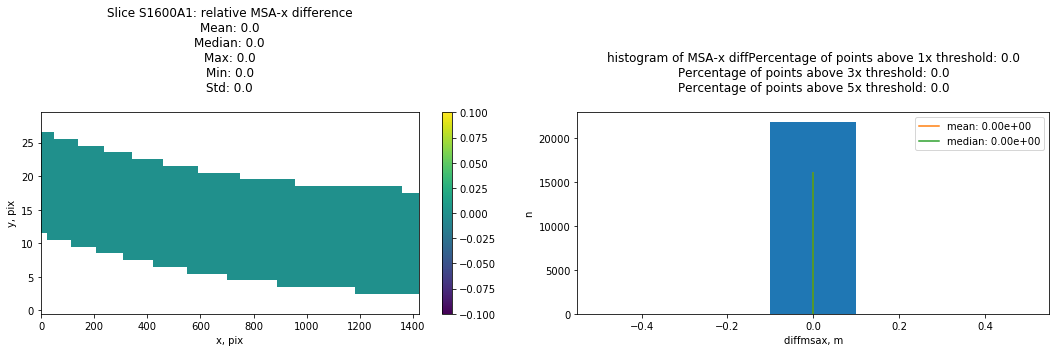

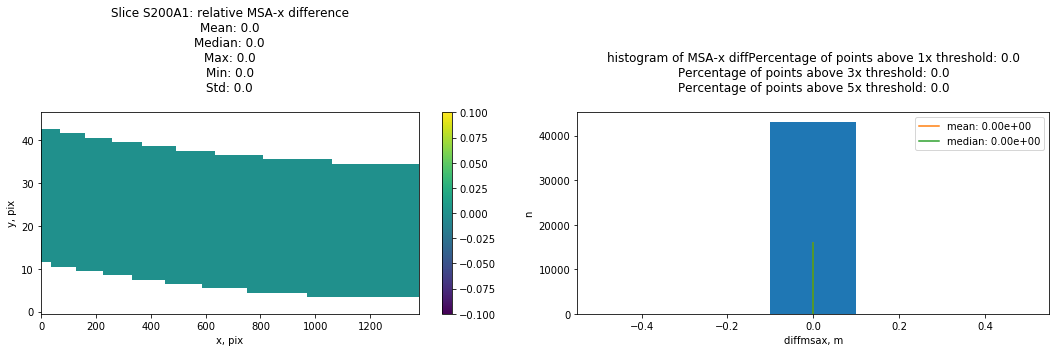

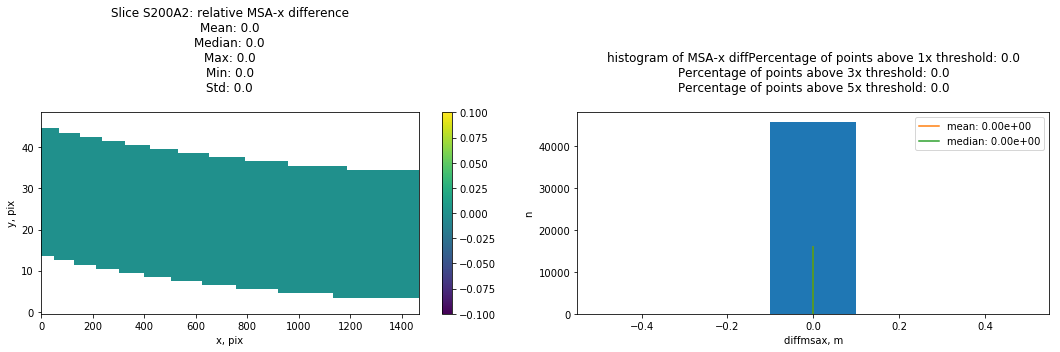

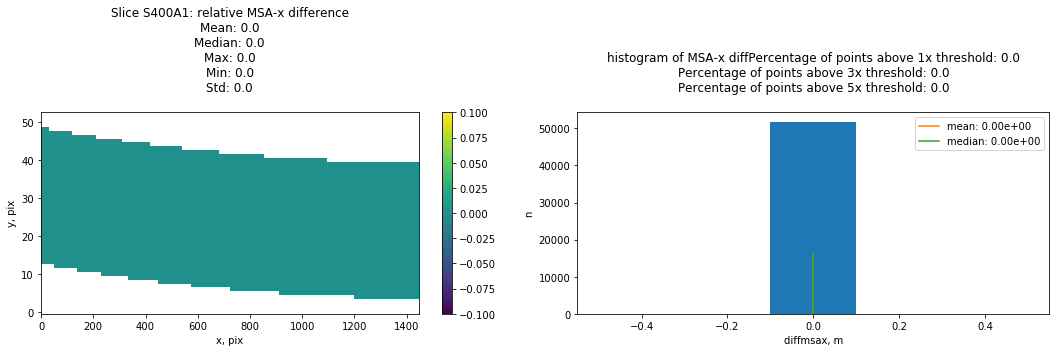

In [16]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msax1 = tr['MSAX1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in MSA positions
    detector2slit = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2slit(x1-1, y1-1)
    
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    mx[~in_slit] = np.nan
    nanind = np.isnan(mx)
    notnan = ~nanind
    
    diffmsax = (mx - msax1) / msax1
    percentage_results = compute_percentage(diffmsax, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsax[notnan])
    median = np.median(diffmsax[notnan])
    dmax = np.max(diffmsax[notnan])
    dmin = np.min(diffmsax[notnan])
    dstd = np.std(diffmsax[notnan])
    
    title1 = "Slice {}: relative MSA-x difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-x diff"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsax, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsax[~np.isnan(diffmsax)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsax, m')
    plt.ylabel('n')
    fig.tight_layout()

### MSA to Slit Y - S200A1

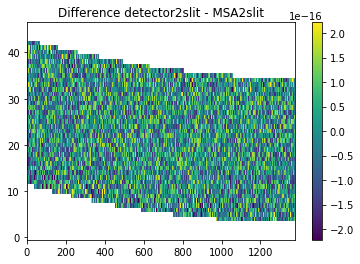

In [17]:
tr = fits.open('esa/Trace_SLIT_A_200_1_V84600010001P0000000002101_39547_JLAB88.fits')
lam1 = tr['LAMBDA1'].data
slit1 = tr['SLITY1'].data
msay = tr['MSAY1'].data
pyw = wcs.WCS(tr['LAMBDA1'].header)
slice_id = map_slit_names[tr[0].header['SLITID']]
tr.close()

# Create x, y indices using the Trace WCS
y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
x1, y1 = pyw.all_pix2world(x, y, 0)

# Get the WCS for this particular slice
wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)

# Compute the slit-y positions
detector2slit = wcs_slice.get_transform("detector", "slit_frame")
sx, sy, lam = detector2slit(x1-1, y1-1)

# Compute the MSA-y positions
detector2msa = wcs_slice.get_transform("detector", "msa_frame")
mx, my, mlam = detector2msa(x1-1, y1-1)

# Compute the slit-y positions usin gthe inverse of slit_to_msa transform
msa2slit = wcs_slice.get_transform("msa_frame", "slit_frame")
msx, msy, mslam = msa2slit(mx, my, mlam)


# Use slit locations between -.5 and .5
in_slit = np.logical_and(slit1<.5, slit1>-.5)
sy[~in_slit] = np.nan
nanind = np.isnan(sy)
notnan = ~nanind

diffslit = (sy - slit1)

diffmy = (my - msay)

diff_slitinverse_slitforward = msy -sy

plt.imshow(diff_slitinverse_slitforward, aspect='auto')
plt.colorbar()
plt.title("Difference detector2slit - MSA2slit")

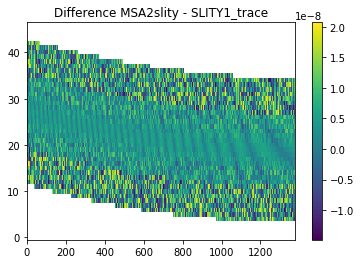

In [18]:
dm = msy - slit1
dm[slit1==-1]=np.nan
plt.imshow(dm, aspect='auto')
plt.colorbar()
plt.title("Difference MSA2slity - SLITY1_trace")